In [76]:
import logging
from autologging import logged, traced, TRACE
logging.basicConfig(level=logging.INFO, format="%(name)s.%(funcName)s\t%(message)s")

import tensorflow as tf
from tensorflow import keras
(train_images, train_labels), (test_images, test_labels) = keras.datasets.fashion_mnist.load_data()
train_images = train_images[:len(train_images)//1]
test_images = test_images[:len(test_images)//1]
logging.info(f"train_images: {train_images.shape} {train_images.dtype}")

root.<module>	train_images: (60000, 28, 28) uint8


In [77]:

import numpy as np

@logged
def prepare_images(img_array:np.ndarray, sz=64):
    from skimage.transform import resize
    img_array = (img_array / 255.0).astype(np.float32)
    prepare_images._log.info(f"img_array: {img_array.shape} {img_array.dtype}")    
    img_array = [resize(img_array[n], (sz,sz)) for n in range(img_array.shape[0])]
    img_array = np.reshape(img_array, (len(img_array),sz,sz,1))
    prepare_images._log.info(f"img_array: {img_array.shape} {img_array.dtype}")
    return img_array

train_images = prepare_images(train_images)
test_images = prepare_images(test_images)

__main__.prepare_images	img_array: (60000, 28, 28) float32
__main__.prepare_images	img_array: (60000, 64, 64, 1) float32
__main__.prepare_images	img_array: (10000, 28, 28) float32
__main__.prepare_images	img_array: (10000, 64, 64, 1) float32


In [78]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *

def create_encoder(sz=64, latent_dim=8, locally_connected_channels=2, act_func='softplus'):
    """ creates the encoder side of the autoencoder, for the parameters sz and latent_dim
    # Static parameters
        sz (int): sz x sz input
        latent_dim (int): gaussian dimensions
        locally_connected_channels = 2
    # Arguments
        <none>
    # Returns
        retina: the input layer
        encoder: the encoder model
        shape: shape of last input layer
        [z_mean, z_log_var, z]: tensors for latent space
    """

    return Sequential([
        Input(shape=(sz,sz,1), name='retina_{}'.format(sz)),

        Conv2D(16, (5,5), name='v1_conv2d', activation=act_func, padding='same'),
        MaxPooling2D((2,2), name='v1_maxpool', padding='same'),
        SpatialDropout2D(0.1, name='v1_dropout'),

        Conv2D(16, (3,3), name='v2_conv2d', activation=act_func, padding='same'),
        MaxPooling2D((2,2), name='v2_maxpool', padding='same'),

        Conv2D(32, (3,3), name='v4_conv2d', activation=act_func, padding='same'),
        MaxPooling2D((2,2), name='v4_maxpool', padding='same'),

        Conv2D(32, (3,3), name='pit_conv2d', activation=act_func, padding='same'),
        Conv2D(64, (3,3), name='cit_conv2d', activation=act_func, padding='same'),
        LocallyConnected2D(locally_connected_channels, (3,3), name='ait_local',        
            activation=act_func),
        ActivityRegularization(l1=0.0e-4, l2=0.0e-4, name='ait_regular'),

        # generate latent vector Q(z|X)
        Flatten(name='pulvinar_flatten'),
        Dense(latent_dim, name='pulvinar_dense', activation=act_func),
        Dense(latent_dim+latent_dim, name='z_mean_log_var'),
    ], name='v1_to_pulvinar_encoder')

encoder = create_encoder()
encoder.summary()

retina = encoder.input
print(retina)

dense_shape = encoder.get_layer('ait_local').output_shape
print(dense_shape)

output = encoder.get_layer('z_mean_log_var')
print(output)

Model: "v1_to_pulvinar_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
v1_conv2d (Conv2D)           (None, 64, 64, 16)        416       
_________________________________________________________________
v1_maxpool (MaxPooling2D)    (None, 32, 32, 16)        0         
_________________________________________________________________
v1_dropout (SpatialDropout2D (None, 32, 32, 16)        0         
_________________________________________________________________
v2_conv2d (Conv2D)           (None, 32, 32, 16)        2320      
_________________________________________________________________
v2_maxpool (MaxPooling2D)    (None, 16, 16, 16)        0         
_________________________________________________________________
v4_conv2d (Conv2D)           (None, 16, 16, 32)        4640      
_________________________________________________________________
v4_maxpool (MaxPooling2D)    (None, 8, 8, 32

In [79]:

def create_decoder(dense_shape, latent_dim=8, locally_connected_channels=2,
        act_func='softplus'):
    """ creates the decoder side of the autoencoder, given the input shape
    # Static parameters
        sz (int): sz x sz input
        latent_dim (int): gaussian dimensions
        locally_connected_channels = 2
    # Arguments
        shape: first input layer shape
    # Returns
        decoder: the decoder model
    """

    return Sequential([
        Input(shape=(latent_dim,), name='z_sampling'),
        Dense(dense_shape[1] * dense_shape[2] * dense_shape[3], 
            name='pulvinar_dense_back', activation=act_func),
        Reshape((dense_shape[1], dense_shape[2], dense_shape[3]),
            name='pulvinar_antiflatten'),

        ZeroPadding2D(padding=(1,1), name='ait_padding_back'),
        LocallyConnected2D(locally_connected_channels, (3,3), name='ait_local_back',
            activation=act_func),

        ZeroPadding2D(padding=(1,1), name='cit_padding_back'),
        Conv2DTranspose(64, (3,3), name='cit_conv2d_trans', activation=act_func, padding='same'),
        Conv2DTranspose(32, (3,3), name='pit_conv2d_trans', activation=act_func, padding='same'),
        Conv2DTranspose(32, (3,3), name='v4_conv2d_trans', activation=act_func, padding='same'),
        UpSampling2D((2,2), name='v4_upsample_back'),

        Conv2DTranspose(16, (3,3), name='v2_conv2d_trans', activation=act_func, padding='same'),
        UpSampling2D((2,2), name='v2_upsample_back'),

        Conv2D(1, (5,5), name='v1_conv2d_5x5_back', # activation='sigmoid', == return logits
                            padding='same'),
        UpSampling2D((2,2), name='v1_upsample_back'),
    ], name='pulvinar_to_v1_decoder')

decoder = create_decoder(dense_shape, latent_dim=8)
decoder.summary()

Model: "pulvinar_to_v1_decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pulvinar_dense_back (Dense)  (None, 72)                648       
_________________________________________________________________
pulvinar_antiflatten (Reshap (None, 6, 6, 2)           0         
_________________________________________________________________
ait_padding_back (ZeroPaddin (None, 8, 8, 2)           0         
_________________________________________________________________
ait_local_back (LocallyConne (None, 6, 6, 2)           1368      
_________________________________________________________________
cit_padding_back (ZeroPaddin (None, 8, 8, 2)           0         
_________________________________________________________________
cit_conv2d_trans (Conv2DTran (None, 8, 8, 64)          1216      
_________________________________________________________________
pit_conv2d_trans (Conv2DTran (None, 8, 8, 32

In [80]:
# @traced
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
        -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
        axis=raxis)

# @traced
def reparameterize(mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

# @traced
def compute_loss(encoder, decoder, x):
    mean, logvar = tf.split(encoder(x), num_or_size_splits=2, axis=1)
    z = reparameterize(mean, logvar)
    x_logit = decoder(z)
    # tf.print(f"x_logit, x.shape = {x_logit}, {x.shape}")
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    # tf.print(f"cross_ent.shape = {cross_ent.shape}")
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def train_step(encoder, decoder, x, optimizer):
    """Executes one training step and returns the loss.
    This function computes the loss and gradients, and uses the latter to
    update the model's parameters.
    """
    all_trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    with tf.GradientTape() as tape:
        loss = compute_loss(encoder, decoder, x)
        # tf.print(f"loss value = {loss}")
    gradients = tape.gradient(loss, all_trainable_variables)
    optimizer.apply_gradients(zip(gradients, all_trainable_variables))

In [83]:
from time import time
from datetime import datetime
from pathlib import Path
log_dir = Path('.') / 'logs' / 'fit' / datetime.now().strftime("%Y%m%d-%H%M%S")
print(log_dir)

tb_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
tb_callback.set_model(encoder)
logs = { 'loss':None, 'mean_absolute_error':None, 'output':None }
tb_callback.on_train_begin()

batch_size = 16
optimizer = tf.keras.optimizers.Adam(1e-4)

for epoch in range(1, 11):
    tb_callback.on_epoch_begin(epoch)
    start_time = time()
    step = 0
    while (step+1) * batch_size < train_images.shape[0]:
        # input_train_x = tf.expand_dims(train_x, axis=0)
        input_train_x = train_images[step*batch_size:(step+1)*batch_size,...]
        if not (step % 10000): logging.info(f"{step}: {input_train_x.shape}")
        tb_callback.on_train_batch_begin(step, logs=logs)
        train_step(encoder, decoder, input_train_x, optimizer)
        tb_callback.on_train_batch_end(step, logs=logs)
        step += 1
    end_time = time()

    loss = tf.keras.metrics.Mean()
    step = 0
    while (step+1) * batch_size < test_images.shape[0]:
        input_test_x = test_images[step*batch_size:(step+1)*batch_size,...]
        if not (step % 1000): logging.info(f"{step}: {input_test_x.shape}")
        loss(compute_loss(encoder, decoder, input_test_x))
        step += 1
    elbo = -loss.result()
    logging.info(f"Epoch: {epoch}, test ELBO: {elbo}, time elapsed: {end_time - start_time}")
    tb_callback.on_epoch_end(epoch)

tb_callback.on_train_end()

root.<module>	0: (16, 64, 64, 1)
logs\fit\20210316-175543
root.<module>	0: (16, 64, 64, 1)
root.<module>	Epoch: 1, test ELBO: -2037.551513671875, time elapsed: 54.80680751800537
root.<module>	0: (16, 64, 64, 1)
root.<module>	0: (16, 64, 64, 1)
root.<module>	Epoch: 2, test ELBO: -2037.486328125, time elapsed: 56.64940595626831
root.<module>	0: (16, 64, 64, 1)
root.<module>	0: (16, 64, 64, 1)
root.<module>	Epoch: 3, test ELBO: -2037.4468994140625, time elapsed: 54.33694267272949
root.<module>	0: (16, 64, 64, 1)
root.<module>	0: (16, 64, 64, 1)
root.<module>	Epoch: 4, test ELBO: -2037.394775390625, time elapsed: 51.805805683135986
root.<module>	0: (16, 64, 64, 1)
root.<module>	0: (16, 64, 64, 1)
root.<module>	Epoch: 5, test ELBO: -2037.3736572265625, time elapsed: 55.53592371940613
root.<module>	0: (16, 64, 64, 1)
root.<module>	0: (16, 64, 64, 1)
root.<module>	Epoch: 6, test ELBO: -2037.3291015625, time elapsed: 55.88693308830261
root.<module>	0: (16, 64, 64, 1)
root.<module>	0: (16, 64, 

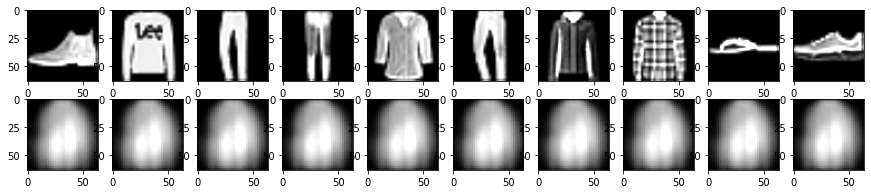

In [82]:
import matplotlib.pyplot as plt
test_latent = encoder(test_images[0:10,...])

def sigmoid(x):  
    return np.exp(-np.logaddexp(0, -x))

re_test_images = decoder(test_latent[...,0:8])
re_test_images = sigmoid(re_test_images)

quantiles = [0.05, 0.95]

fig, ax = plt.subplots(2,10,figsize=(15,3))
for n in range(10):
    q_test = np.quantile(test_images[n],quantiles)
    ax[0][n].imshow(test_images[n], cmap='gray', vmin=q_test[0], vmax=q_test[1])

    reshape_test_image = np.reshape(re_test_images[n], (64,64))
    q_re = np.quantile(reshape_test_image,quantiles)
    ax[1][n].imshow(reshape_test_image, cmap='gray', vmin=q_re[0], vmax=q_re[1])